<div style="text-align: right"> 
<a href = "https://nbviewer.jupyter.org/github/siddharthchaini/Improving-Feature-Extraction-RESSPECT/tree/main/"> 
    View online on<br>
    <img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg"
         alt="nbviewer link" style="height: 30px;"/> 
</a>
</div>

# 2. GP-VAE Approach for RESSPECT
<a href = http://cosmostatistics-initiative.org/resspect/>
<img src="https://cosmostatistics-initiative.org/wp-content/uploads/2019/04/coin_desc_3.png" alt="Logo" style="width: 250px;"/>
</a>

**Authors**: Siddharth Chaini, Johann Cohen-Tanugi

This is the second Jupyter notebook (of a total of 2) describing the different feature extraction methods explored by Siddharth and Johann in June & July, 2021.

For RESSPECT, a light curve is fit to a function and then the fit parameters are then used in the RESSPECT pipeline as features for training. You can read more about this here: https://arxiv.org/pdf/2010.05941.pdf

In this notebook, we will look at a deep learning based approach for feature extraction, GP-VAE.

In [1]:
import datetime
print('Last Updated On:', datetime.datetime.now().strftime("%d %B, %Y"))

Last Updated On: 29 July, 2021


In [2]:
# Some prerequisites

import numpy as np
np.random.seed(42)
np.set_printoptions(suppress=True)
from scipy.optimize import least_squares, curve_fit
from matplotlib import pylab as plt
import pandas as pd
import glob
import time
from tqdm.notebook import tqdm
import os

import warnings
from scipy.optimize import OptimizeWarning
warnings.simplefilter("error", OptimizeWarning)

import seaborn as sns
sns.set()

def plot_allbands_df(df,title=None,ax=plt):
    ugrizYcolors = ["violet","green","red","darkred","grey","black"]
    for i,band in enumerate("ugrizY"):
        subdf = df[df["band"]==band].reset_index(drop=True)
        x = subdf["mjd"]
        y = subdf["flux"]
        yerr = subdf["fluxerr"]
#         ax.errorbar(x,y,yerr=yerr,ls = "None",color=ugrizYcolors[i])
        ax.scatter(x,y,s=5,label=band,color=ugrizYcolors[i])
        if title is not None:
            if ax is not plt:
                ax.set_title(title)
            else:
                ax.title(title)
    return ax


### 1. About GP-VAE

Gaussian-Process Variational Autoencoders (GP-VAE ; [Fortuin et. al. 2020](https://arxiv.org/pdf/1907.04155.pdf)) is an approach developed for dimensionality reduction and data imputation. It combines Variational Autoencoders (VAEs) with Gaussian Processes (GPs) in the following way:

- Deep VAEs are used to map the original time series data with missing values into a latent space.
- A GP then utilizes latent representations to capture the temporal correlations in the time series.

A detailed description of this is available in [Fortuin et. al. (2020)](https://arxiv.org/pdf/1907.04155.pdf).

For our use case, we wish to use the latent space of the GP-VAE as features for the light curves in 6 passbands. We use code provided by the authors on [GitHub](https://github.com/ratschlab/GP-VAE)<sup>[*](#myfootnote1)</sup>.

<a name="myfootnote1">*</a> Note: The original code was based on TensorFlow 1.15 and so we made small modifications on a [fork](https://github.com/siddharthchaini/GP-VAE) using [TensorFlow's Upgrade Script](https://www.tensorflow.org/guide/upgrade) to make it compatible for TensorFlow 2+.

### 2. Data & Preprocessing

PLAsTiCC/RESSPECT data consists of light-curve data in the form of CSVs with readings at a particular timestamp, indicating the mjd of observation, the passband in which it was observed, and the flux values and flux errors.

For example:

In [3]:
df = pd.read_csv("sample_data/plasticc/130779836_uLens.csv")
df

,mjd,band,flux,fluxerr,detected_bool
0,59710.4130,i,571.036438,38.534260,1
1,59715.3319,Y,749.963562,32.526573,1
2,59722.3088,z,811.698425,33.418995,1
3,59728.4313,z,791.284973,46.716145,1
4,59729.2258,i,834.375305,28.976799,1
...,...,...,...,...,...
113,60555.9838,z,-39.881969,46.477093,0
114,60560.0459,g,14.894439,18.947685,0
115,60571.0225,Y,30.593130,50.695290,0
116,60585.9974,z,-23.471439,44.819859,0


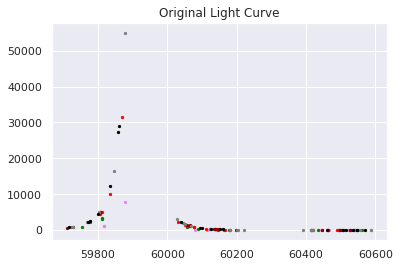

In [4]:
tempplt = plot_allbands_df(df)
tempplt.title("Original Light Curve")
tempplt.show()

This needs to be modified into a conventional time series having a constant length before being fed to the GP-VAE as input.

We choose the constant length to be 200 days as a heuristic, because that covers almost all transient activity based on our testing (using ```detected_bool=1```) (ToDo: EXPLAIN MORE)

If either of the following is true:
- More than 3 observations in a span of 5 consecutive days have a ratio >=2
- detected_bool = 1
then the light curve is cropped to a length of 200 days roughly centred about the point when either of the above happens.    

When neither of the above 2 criteria are fulfilled, the first 200 days are considered by default (ToDo: EXPLAIN MORE about why these criteria were chosen.)

In [5]:
def center_bigdf(df):
    '''
    If either of the following is true:
        - More than 3 observations in a span of 5 consecutive days have a ratio >=2
        - detected_bool = 1
    then the light curve is cropped to a length of 200 days roughly centred about the point when either of the above happens.
    
    When neither of the above 2 criteria are fulfilled, the first 200 days are considered by default

    '''
    
    # Start mjd from 0
    df["mjd"] = df["mjd"] - df["mjd"][0]
    df["ratio"] = abs(df["flux"]/df["fluxerr"])

    df["ratio2bool"] = 0

    subdf_detected = df[df["detected_bool"]==1]
    subdf_ratio2 = df[df["ratio"]>=2]

    # Find the mjd where more than 3 observations in a span of 5 consecutive days have a flux-fluxerr ratio >=2
    smalldf = subdf_ratio2.loc[abs(subdf_ratio2.mjd.diff(periods=-1))<=5]
    for i in range(3):
        smalldf = smalldf[abs(smalldf.mjd.diff(periods=-1))<=5]

    
    if len(subdf_detected)>0 and len(smalldf)>0:
        detected_bool_minmjd = subdf_detected.mjd.values[0]
        custom_bool_minmjd = smalldf.mjd.values[0]

        diffmjd = abs(detected_bool_minmjd - custom_bool_minmjd)/2

        minmjdstart = min(detected_bool_minmjd, custom_bool_minmjd)
        maxmjdstart = max(detected_bool_minmjd, custom_bool_minmjd)

        mjdlim_lower = minmjdstart - (100-diffmjd)
        mjdlim_upper = maxmjdstart + (100-diffmjd)

    elif len(subdf_detected)>0:
        detected_bool_minmjd = subdf_detected.mjd.values[0]
        mjdlim_lower = detected_bool_minmjd - 100
        mjdlim_upper = detected_bool_minmjd + 100

    elif len(smalldf)>0:
        custom_bool_minmjd = smalldf.mjd.values[0]
        mjdlim_lower = custom_bool_minmjd - 100
        mjdlim_upper = custom_bool_minmjd + 100

    else:
        mjdlim_lower = 0
        mjdlim_upper = 200
    
    # Lower limit can't be -ve
    if mjdlim_lower<0:
        mjdlim_upper = mjdlim_upper + abs(mjdlim_lower)
        mjdlim_lower = 0

    assert (mjdlim_upper-mjdlim_lower)==200
    
    df.loc[(df["mjd"] >= mjdlim_lower) & (df["mjd"] <= mjdlim_upper),"ratio2bool"] = 1
    
    newdf = df[df["ratio2bool"]==1].reset_index(drop=True)
    
    return newdf

In [6]:
newdf = center_bigdf(df)
newdf

,mjd,band,flux,fluxerr,detected_bool,ratio,ratio2bool
0,0.0000,i,571.036438,38.534260,1,14.818928,1
1,4.9189,Y,749.963562,32.526573,1,23.056950,1
2,11.8958,z,811.698425,33.418995,1,24.288535,1
3,18.0183,z,791.284973,46.716145,1,16.938148,1
4,18.8128,i,834.375305,28.976799,1,28.794599,1
5,42.7361,g,759.056091,23.736109,1,31.978960,1
6,58.7269,z,2148.493896,25.189192,1,85.294276,1
7,61.7802,Y,2285.122559,79.410194,1,28.776187,1
8,65.8392,z,2471.021973,27.277407,1,90.588595,1
9,66.8824,Y,2618.357910,46.559090,1,56.237309,1


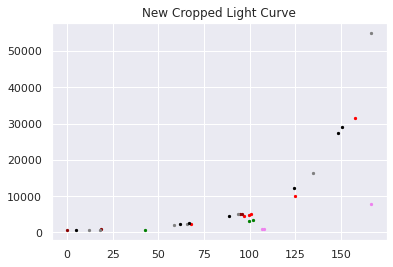

In [7]:
tempplt = plot_allbands_df(newdf)
tempplt.title("New Cropped Light Curve")
tempplt.show()


---
The full code for the above preprocessing and centering can be found on these GitHub repositories:
- https://github.com/siddharthchaini/centering-perfect-sims-resspect: Centering of RESSPECT Perfect Simulation Light Curves
- https://github.com/siddharthchaini/centering-time-series-plasticc: Centering of PLAsTiCC Data

**(NOTE: These will be ported over to the current repository soon. ToDo)**

### 3. Downloading the code for GP-VAE

Based on the TensorFlow version, different code will be used.

In [8]:
import tensorflow as tf
import subprocess
tf_v = tf.__version__
print(f"TF Version is: {tf_v}")

if int(tf_v[0])==2:
    git_url = "https://github.com/siddharthchaini/GP-VAE"
elif int(tf_v[0])==1:
    git_url = "https://github.com/ratschlab/GP-VAE"

TF Version is: 2.5.0


In [10]:
dl_loc = "../.repos/GP-VAE" # Directory where GP-VAE Code is saved / to be saved
if not os.path.isdir(dl_loc):
    print("Downloading ...")
    # Download code
    process = subprocess.run(["git","clone", git_url, dl_loc], stdout=subprocess.PIPE, universal_newlines=True)
    if process.returncode == 0:
        print("Downloaded successfully")
    else:
        print("Error downloading.")
        print(process.stdout)
else:
    print("Already found GP-VAE directory")

Already found GP-VAE directory


### Let's now implement GP-VAE for the Physionet data as described in [Fortuin et. al. (2020)](https://arxiv.org/pdf/1907.04155.pdf)

References: 
1. https://www.kaggle.com/siddharthchaini/gpvae-raw?scriptVersionId=67899219
2. https://www.kaggle.com/siddharthchaini/gpvae-raw-visualisation?scriptVersionId=68152622

---

TODO

---

### Let's now try to apply it to RESSPECT Simulation Data

References: 
1. https://www.kaggle.com/siddharthchaini/gpvae-raw-plasticc?scriptVersionId=66968645
2. https://www.kaggle.com/siddharthchaini/visualisation-gpvae-raw-plasticc?scriptVersionId=67006906